# **Multiclass Sentiment Prediction Models**

This notebook demonstrates how to build and train models for multiclass sentiment prediction using Convolutional Neural Networks (CNNs) and Recurrent Neural Networks (RNNs). The workflow includes data preprocessing, model building, training, and evaluation.

---

## Table of Contents

1. [Introduction](#1-introduction)  
2. [Dataset Overview](#2-dataset-overview)  
3. [Data Preprocessing](#3-data-preprocessing)  
4. [Model Architectures](#4-model-architectures)  
    - [CNN Model](#cnn-model)  
    - [RNN Model](#rnn-model)  


## **1. Introduction**

Multiclass sentiment prediction is a supervised learning task where the model predicts the sentiment category of a given text input. This notebook explores two powerful approaches for this task:  
1. **Convolutional Neural Networks (CNNs)** for capturing spatial dependencies in the data.  
2. **Recurrent Neural Networks (RNNs)** for sequential processing of text data.  

We use TensorFlow and Keras for implementation and evaluate the performance of each model.

In [1]:
import pandas as pd
import numpy as np
import os

from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
import torch
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.layers import LSTM, Input, Attention, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


## **2. Dataset Overview**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

CSV_path = '/content/drive/MyDrive/DATASCI-266_FinalProject/combined_VERY_VERY_FINAL.csv'
df = pd.read_csv(CSV_path)
df.head()

Mounted at /content/drive


,news_org,title,summary,total_reactions,article_screenshot_s3_link,reactions_screenshot_s3_link,article_sc_date,reactions_sc_date,total_comments,total_shares,...,ratio_angry,ratio_care,cleaned_title,cleaned_summary,vader_sentiment_score,embedding,vader_sentiment_class,sentiment_score,headline_sentiment_class,news_label
0,The_Wall_Street_Journal,Would You Zap Yourself With Electricity to Get...,One of the latest trends in boutique fitness i...,27,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:07:51,2024-10-14 16:07:55,4,3,...,0.037037,0.000000,would zap electricity get shape,one late trend boutique fitness electrify lite...,-0.1027,[-9.65170786e-02 -6.67401850e-02 2.26862580e-...,1,-0.011845,1,0
1,The_Wall_Street_Journal,Tesla Considers $775 Million Texas Factory Exp...,Tesla is considering more than $775 million in...,108,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:00,2024-10-14 16:08:05,15,3,...,0.009259,0.009259,tesla considers million texas factory expansion,tesla consider million expansion electricvehic...,-0.4215,[-3.15038592e-01 8.39137062e-02 2.63236046e-...,1,0.005470,2,1
2,The_Wall_Street_Journal,Steven Spielberg’s ‘The Fabelmans’ Wins Best D...,"“The Fabelmans,” Steven Spielberg’s tale of a ...",184,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:24,2024-10-14 16:08:28,83,4,...,0.005435,0.010870,steven spielberg fabelmans win best drama,fabelmans steven spielberg tale childhood indo...,0.8402,[-5.72552562e-01 1.90420046e-01 2.98330992e-...,3,0.012617,2,1
3,The_Wall_Street_Journal,Abbott Elementary' Is a Golden Globes Favorite,Abbott Elementary' won three awards at the Gol...,273,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:33,2024-10-14 16:08:38,38,6,...,0.003663,0.007326,abbott elementary golden globe favorite,abbott elementary three award golden globe inc...,0.4588,[-6.08102679e-01 -1.03185527e-01 1.87640250e-...,2,0.093773,2,1
4,The_Wall_Street_Journal,An Absent Cate Blanchett Wins Best Actress in ...,Cate Blanchett proved herself a movie maestro ...,263,https://nlp-project-screenshots.s3.amazonaws.c...,https://nlp-project-screenshots.s3.amazonaws.c...,2024-10-14 16:08:45,2024-10-14 16:08:53,7,10,...,0.003802,0.007605,absent cate blanchett win best actress motion ...,cate blanchett prove movie maestro tr earn bes...,0.8402,[-7.72164404e-01 1.47608727e-01 -2.20909327e-...,3,0.063339,2,1


In [ ]:
# Check distribution of sentiment classes
df['headline_sentiment_class'].value_counts()

,count
headline_sentiment_class,
1,2470
2,2261
0,1586
3,305


## **3. Data Preprocessing**

The text data is tokenized, padded, and converted into a format suitable for both CNN and RNN models.


In [3]:
# Separate features (headlines) and labels (sentiment classes)
X = df['title']
y = df['headline_sentiment_class']

# Split the data into training (60%), validation (20%), and testing (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(np.array(X_train).reshape(-1, 1), y_train)
X_train_resampled = pd.Series(X_train_resampled.flatten())
X_train = X_train_resampled
y_train = y_train_resampled # Update y_train with resampled labels

# Now you have X_train, y_train, X_val, y_val, X_test, and y_test
# with balanced classes and the desired split
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (5992,), (5992,)
Validation data shape: (1324,), (1324,)
Testing data shape: (1325,), (1325,)


In [ ]:
print('Class counts in y_train: ', y_train.value_counts())
print('Class counts in y_val: ', y_val.value_counts())
print('Class counts in y_test: ', y_test.value_counts())

Class counts in y_train:  headline_sentiment_class
0    1498
2    1498
1    1498
3    1498
Name: count, dtype: int64
Class counts in y_val:  headline_sentiment_class
1    498
2    457
0    315
3     54
Name: count, dtype: int64
Class counts in y_test:  headline_sentiment_class
2    496
1    474
0    283
3     72
Name: count, dtype: int64


## **4. Model Architectures**

### **4.1 CNN Model**

The CNN architecture includes:
- **Embedding Layer**: Transforms integer token sequences into dense vector representations.  
- **Convolutional Layers**: Capture spatial dependencies using `Conv1D`.  
- **Global Max Pooling**: Reduces dimensionality by extracting the most significant features.  
- **Dense Layers**: Fully connected layers with ReLU activation for feature extraction and softmax activation for multiclass classification.


In [4]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

def create_cnn_model(vocab_size=20000, embedding_dim=100, max_length=128, num_classes=4):
    """
    Creates and compiles a CNN model for multiclass classification with enhanced regularization to prevent overfitting.
    """
    # Tokenize the text data
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='post')
    X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_length, padding='post')

    # Build the CNN model
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),

        # Convolutional block
        Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.02)),  # Increased L2
        BatchNormalization(),
        Dropout(0.5),  # Increased dropout for better regularization
        GlobalMaxPooling1D(),

        # Dense block
        Dense(128, activation='relu', kernel_regularizer=l2(0.02)),
        BatchNormalization(),
        Dropout(0.5),

        # Output layer
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.02))
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, X_train_seq, X_val_seq

In [5]:
cnn_model, X_train_seq, X_val_seq = create_cnn_model()
cnn_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.3237 - loss: 6.3579 - val_accuracy: 0.0408 - val_loss: 4.6907
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 138ms/step - accuracy: 0.6330 - loss: 3.6926 - val_accuracy: 0.3610 - val_loss: 3.3330
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.8187 - loss: 2.2050 - val_accuracy: 0.4615 - val_loss: 2.3579
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 25s 122ms/step - accuracy: 0.9172 - loss: 1.3178 - val_accuracy: 0.4955 - val_loss: 1.8692
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 32s 73ms/step - accuracy: 0.9432 - loss: 0.8383 - val_accuracy: 0.4924 - val_loss: 1.6579
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - accuracy: 0.9672 - loss: 0.5615 - val_accuracy: 0.4902 - val_loss: 1.5552
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 74ms/step - accuracy: 0.9762 - loss: 0.4024 - val_accuracy: 0.4902 - val_loss: 1.5318
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.9790 - loss: 0.3281 - val_accur

In [ ]:
cnn_model.save('cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# cnn_model = load_model('cnn_model.h5')

# Tokenize and pad the test data
vocab_size = 20000  # Same vocab size used during training
max_length = 128  # Same max length used during training
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train) # Use the same tokenizer fitted on training data

X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post')

# Evaluate the model on the test set
loss, accuracy = cnn_model.evaluate(X_test_seq, y_test, verbose=0)
print(f"Test Accuracy: {accuracy}")

# Make predictions
y_pred = np.argmax(cnn_model.predict(X_test_seq), axis=-1)

# Generate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Test Accuracy: 0.498113214969635
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
              precision    recall  f1-score   support

           0       0.49      0.44      0.46       283
           1       0.49      0.49      0.49       474
           2       0.51      0.60      0.55       496
           3       0.40      0.08      0.14        72

    accuracy                           0.50      1325
   macro avg       0.47      0.40      0.41      1325
weighted avg       0.49      0.50      0.49      1325



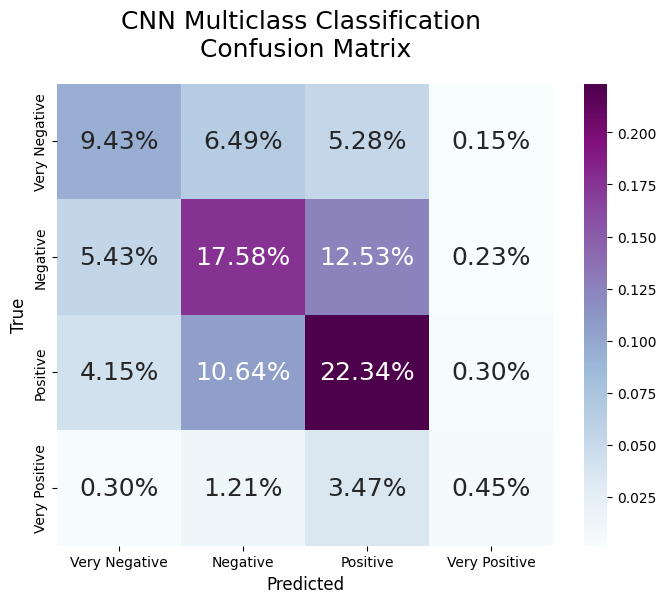

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

path_output_images = '/content/drive/MyDrive/DATASCI-266_FinalProject/Plots/'

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='BuPu',
            xticklabels=['Very Negative', 'Negative', 'Positive', 'Very Positive']
            , yticklabels=['Very Negative', 'Negative', 'Positive', 'Very Positive'],
            annot_kws={"size": 18})
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Multiclass Classification \nConfusion Matrix', size=18,
             pad=20)
plt.savefig(path_output_images + 'plot_CM_CNN_Multi.png', transparent=True)
plt.show()

In [13]:
# Create a DataFrame to easily access the original text
results_df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted_label': y_pred}) # Use y_pred instead of predicted_classes

# True Positives (correctly predicted positive)
true_positives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 1)].head(3)
print("True Positives:")
print(true_positives)

# True Negatives (correctly predicted negative)
true_negatives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 0)].head(3)
print("\nTrue Negatives:")
print(true_negatives)

# False Positives (incorrectly predicted positive)
false_positives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)].head(3)
print("\nFalse Positives:")
print(false_positives)

# False Negatives (incorrectly predicted negative)
false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)].head(3)
print("\nFalse Negatives:")
false_negatives

True Positives:
                                                   text  true_label  \
4999  City Summons Reporter to Court After He Asked ...           1   
1730  Basal cell carcinoma: What to know following B...           1   
2945  GOP Presidential Debate Could Be an Embarrassi...           1   

      predicted_label  
4999                1  
1730                1  
2945                1  

True Negatives:
                                                   text  true_label  \
4240  Alabama mayor's apparent suicide underscores t...           0   
5640  THE OFFICER WHO ARRESTED ELIJAH MCCLAIN HAS BE...           0   
907   Alex Murdaugh's surviving son doesn't deny dad...           0   

      predicted_label  
4240                0  
5640                0  
907                 0  

False Positives:
                                                   text  true_label  \
1599  Opinion | Inside the far right's roadmap to in...           0   
5633  Wheelchair passenger says he had to dra

,text,true_label,predicted_label
31,Opinion | Brazil Gets a Democracy Test,1,0
2177,Prominent 22-year-old Palestinian protester Ah...,1,0
4085,Trump and DeSantis campaigns lobby Florida GOP...,1,0


### **4.2 RNN Model**

The RNN architecture includes:
- **Embedding Layer**: Similar to the CNN model, this layer converts tokens into dense vectors.  
- **Recurrent Layers**: Includes GRU or LSTM layers to process sequential dependencies in the text.  
- **Dense Layers**: Fully connected layers with softmax activation for classification.

In [14]:
def create_rnn_model(vocab_size=20000, embedding_dim=100, max_length=128, hidden_units=128, num_classes=4):
    """
    Creates and compiles an RNN model with LSTM layers for binary classification.
    """
    # Tokenize the text data
    tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
    tokenizer.fit_on_texts(X_train)
    X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_length, padding='post')
    X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=max_length, padding='post')

    # Build the RNN model
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length, name="embedding_layer"),
        LSTM(hidden_units, return_sequences=True, name="lstm_layer"),
        GlobalMaxPooling1D(name="global_max_pooling"),
        Dense(64, activation='relu', name="dense_layer"),
        Dropout(0.3, name="dropout_layer"),
        Dense(num_classes, activation='softmax', name="output_layer")
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, X_train_seq, X_val_seq

In [15]:
rnn_model, X_train_seq, X_val_seq = create_rnn_model()
rnn_model.fit(
    X_train_seq, y_train,
    validation_data=(X_val_seq, y_val),
    epochs=10,
    batch_size=32
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 73s 373ms/step - accuracy: 0.2586 - loss: 1.3862 - val_accuracy: 0.3837 - val_loss: 1.3810
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - accuracy: 0.4109 - loss: 1.3735 - val_accuracy: 0.3912 - val_loss: 1.3471
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 239ms/step - accuracy: 0.5721 - loss: 1.2626 - val_accuracy: 0.2938 - val_loss: 1.2486
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 84s 247ms/step - accuracy: 0.5115 - loss: 0.9215 - val_accuracy: 0.4169 - val_loss: 1.2265
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 244ms/step - accuracy: 0.5378 - loss: 0.8496 - val_accuracy: 0.4350 - val_loss: 1.2360
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 239ms/step - accuracy: 0.5633 - loss: 0.8803 - val_accuracy: 0.3384 - val_loss: 1.3780
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 81s 236ms/step - accuracy: 0.5096 - loss: 1.0874 - val_accuracy: 0.2462 - val_loss: 1.3180
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 82s 238ms/step - accuracy: 0.5064 - loss: 1.0435 - val

In [ ]:
rnn_model.save('rnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# # Load the saved model
# rnn_model = load_model('rnn_model.h5')

# Tokenize and pad the test data
vocab_size = 20000  # Same vocab size used during training
max_length = 128  # Same max length used during training
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train) # Use the same tokenizer fitted on training data

X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_length, padding='post')

# Evaluate the model on the test set
loss, accuracy = rnn_model.evaluate(X_test_seq, y_test, verbose=0)
print(f"Test Accuracy: {accuracy}")

# Make predictions
y_pred = np.argmax(rnn_model.predict(X_test_seq), axis=-1)

# Generate classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Test Accuracy: 0.31698113679885864
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step
              precision    recall  f1-score   support

           0       0.77      0.19      0.31       283
           1       0.31      0.08      0.13       474
           2       0.37      0.60      0.46       496
           3       0.09      0.43      0.15        72

    accuracy                           0.32      1325
   macro avg       0.39      0.33      0.26      1325
weighted avg       0.42      0.32      0.29      1325



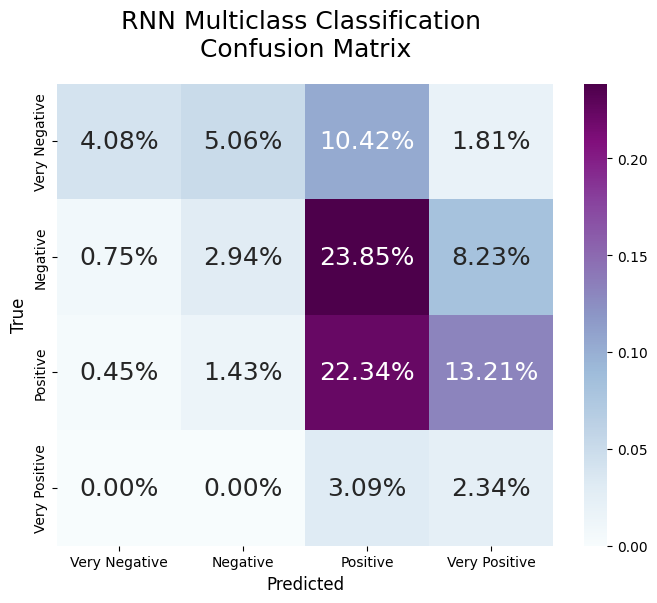

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

path_output_images = '/content/drive/MyDrive/DATASCI-266_FinalProject/Plots/'

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='BuPu',
            xticklabels=['Very Negative', 'Negative', 'Positive', 'Very Positive']
            , yticklabels=['Very Negative', 'Negative', 'Positive', 'Very Positive'],
            annot_kws={"size": 18})
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RNN Multiclass Classification \nConfusion Matrix', size=18,
             pad=20)
plt.savefig(path_output_images + 'plot_CM_RNN_Multi.png', transparent=True)
plt.show()

In [19]:
# Create a DataFrame to easily access the original text
results_df = pd.DataFrame({'text': X_test, 'true_label': y_test, 'predicted_label': y_pred}) # Use y_pred instead of predicted_classes

# True Positives (correctly predicted positive)
true_positives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 1)].head(3)
print("True Positives:")
print(true_positives)

# True Negatives (correctly predicted negative)
true_negatives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 0)].head(3)
print("\nTrue Negatives:")
print(true_negatives)

# False Positives (incorrectly predicted positive)
false_positives = results_df[(results_df['true_label'] == 0) & (results_df['predicted_label'] == 1)].head(3)
print("\nFalse Positives:")
print(false_positives)

# False Negatives (incorrectly predicted negative)
false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['predicted_label'] == 0)].head(3)
print("\nFalse Negatives:")
false_negatives

True Positives:
                                                   text  true_label  \
4999  City Summons Reporter to Court After He Asked ...           1   
5661  Marijuana use raises risk of heart attack, hea...           1   
1832  OceanGate co-founder voiced confidence in sub ...           1   

      predicted_label  
4999                1  
5661                1  
1832                1  

True Negatives:
                                                   text  true_label  \
4240  Alabama mayor's apparent suicide underscores t...           0   
2986  Shooting at Bowling Alley in Maine: Latest Upd...           0   
6067  Six killed, including three children, in Chine...           0   

      predicted_label  
4240                0  
2986                0  
6067                0  

False Positives:
                                                   text  true_label  \
6375  SCARY SCENE: Eagles star carted off field on s...           0   
2995                       Richard Roundtree 

,text,true_label,predicted_label
2177,Prominent 22-year-old Palestinian protester Ah...,1,0
3237,Jets QB Aaron Rodgers to miss rest of NFL seas...,1,0
1414,Aerosmith postpones a month of shows because o...,1,0


## **5. BERT + CNN**

This model is on the next notebook, 04c